In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import warnings

# hide warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,5)

pd.set_option('precision', 3)
pd.set_option('display.max_columns',50)

np.set_printoptions(precision=3)

In [2]:
# load api key
with open('key.txt') as f:
    api_key = f.read()

## Load Data and Inspect

In [3]:
'''Data from: https://www.eia.gov/opendata/qb.php?category=371'''

root_url = f"https://api.eia.gov/series/?api_key={api_key}&series_id="

series_ids = {'NYC_No2_Oil_Price':'PET.EER_EPD2F_PF4_Y35NY_DPG.W',
             'Crude_Oil_Imports':'PET.WCRIMUS2.W',
             'Crude_Oil_Exports':'PET.WCREXUS2.W',
             'US_Fuel_Oil_Imports':'PET.WDIIMUS2.W',
             'US_Fuel_Oil_Exports':'PET.WDIEXUS2.W',
             'US_Supplied':'PET.WRPUPUS2.W'}

In [4]:
import requests
NAME,UNITS,DATA = 0,1,2
# Pull Data
series_pull = dict()
for key in series_ids.keys():
    r = requests.get(root_url + series_ids[key])
    if r.status_code == 200:
        series_pull[key] = [r.json()['series'][0]['name'],
                            r.json()['series'][0]['unitsshort'],
                            r.json()['series'][0]['data']]
        print(f'{key} - data collected successfully...')
    else:
        print(key, f': failed to collect data, status code {r.status_code}')
        
# display series info
print('\nSeries Info:')
for key in series_ids.keys():
    print(series_pull[key][NAME],series_pull[key][UNITS])

NYC_No2_Oil_Price - data collected successfully...
Crude_Oil_Imports - data collected successfully...
Crude_Oil_Exports - data collected successfully...
US_Fuel_Oil_Imports - data collected successfully...
US_Fuel_Oil_Exports - data collected successfully...
US_Supplied - data collected successfully...

Series Info:
New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly $/gal
U.S. Imports of Crude Oil, Weekly Mbbl/d
U.S. Exports of Crude Oil, Weekly Mbbl/d
U.S. Imports of Distillate Fuel Oil, Weekly Mbbl/d
U.S. Exports of Total Distillate, Weekly Mbbl/d
U.S. Product Supplied of Petroleum Products, Weekly Mbbl/d


In [5]:
df = pd.DataFrame(series_pull['NYC_No2_Oil_Price'][DATA],
                  columns=['date',series_pull['NYC_No2_Oil_Price'][NAME]])

x = list(series_pull.keys())
x.remove('NYC_No2_Oil_Price')

for weekly_series in x:
    df = df.merge(pd.DataFrame(series_pull[weekly_series][DATA],
                  columns=['date',series_pull[weekly_series][NAME]]),
                  on='date')

df['date'] = pd.to_datetime(df.date)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 616 entries, 0 to 615
Data columns (total 7 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   date                                                      616 non-null    datetime64[ns]
 1   New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly  616 non-null    float64       
 2   U.S. Imports of Crude Oil, Weekly                         616 non-null    int64         
 3   U.S. Exports of Crude Oil, Weekly                         616 non-null    int64         
 4   U.S. Imports of Distillate Fuel Oil, Weekly               616 non-null    int64         
 5   U.S. Exports of Total Distillate, Weekly                  616 non-null    int64         
 6   U.S. Product Supplied of Petroleum Products, Weekly       616 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
me

None

,date,"New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly","U.S. Imports of Crude Oil, Weekly","U.S. Exports of Crude Oil, Weekly","U.S. Imports of Distillate Fuel Oil, Weekly","U.S. Exports of Total Distillate, Weekly","U.S. Product Supplied of Petroleum Products, Weekly"
0,2022-03-18,3.303,6486,3844,172,931,21124
1,2022-03-11,3.751,6395,2936,222,1415,20652
2,2022-03-04,3.334,6319,2422,274,1074,21210
3,2022-02-25,2.690,5767,3796,403,749,20830
4,2022-02-18,2.736,6828,2686,416,960,21483


## Extract Features

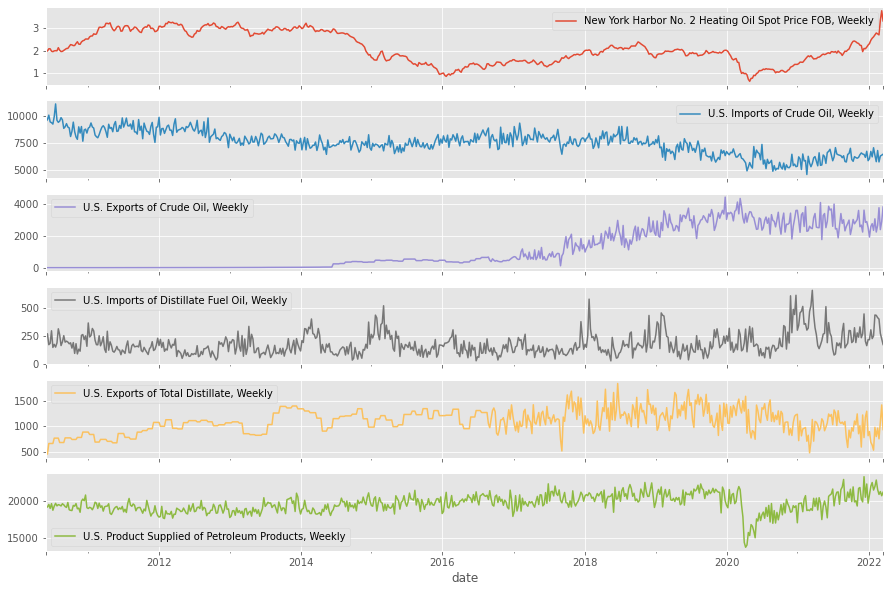

In [12]:
_=df.set_index('date',drop=True).plot(subplots=True,figsize=(15,10))

In [26]:
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame

make_forecasting_frame(df[['date','New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly']],
                       kind='univariate',
                       max_timeshift=52,
                      rolling_direction=1)
# df_rolled = df[['date','New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly']]
# df_rolled['id'] = len(df.index)*[1]
# display(df_rolled)
# df_rolled = roll_time_series(df_rolled,
#                             column_sort='date',max_timeshift=52,min_timeshift=52,column_id='id')
# df_rolled.head(10)

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [23]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
df_features = extract_features(df_rolled,column_id='id',column_sort='date',
                               default_fc_parameters=EfficientFCParameters()
                              )
df_features.head()

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 15/15 [00:30<00:00,  2.06s/it]


New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly__variance_larger_than_standard_deviation  \
1 2011-06-03                                                0.0                                                   
  2011-06-10                                                0.0                                                   
  2011-06-17                                                0.0                                                   
  2011-06-24                                                0.0                                                   
  2011-07-01                                                0.0                                                   

              New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly__has_duplicate_max  \
1 2011-06-03                                                0.0                             
  2011-06-10                                                0.0                             
  2011-06-17                                                0.0                             
  2011-06-24                                                0.0                             
  2011-07-01                                                0.0                             

              New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly__has_duplicate_min  \
1 2011-06-03                                                0.0                             
  2011-06-10                                                0.0                             
  2011-06-17                                                0.0                             
  2011-06-24                                                0.0                             
  2011-07-01                                                0.0                             

              New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly__has_duplicate  \
1 2011-06-03                                                1.0                         
  2011-06-10                                                1.0                         
  2011-06-17                                                1.0                         
  2011-06-24                                                1.0                         
  2011-07-01                                                1.0                         

              New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly__sum_values  \
1 2011-06-03                                            131.320                      
  2011-06-10                                            132.410                      
  2011-06-17                                            133.459                      
  2011-06-24                                            134.228                      
  2011-07-01                                            135.010                      

              New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly__abs_energy  \
1 2011-06-03                                            334.645                      
  2011-06-10                                            340.156                      
  2011-06-17                                            345.417                      
  2011-06-24                                            349.212                      
  2011-07-01                                            353.078                      

              New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly__mean_abs_change  \
1 2011-06-03                                              0.054                           
  2011-06-10                                              0.055                           
  2011-06-17                                              0.054                           
  2011-06-24                                              0.057                           
  2011-07-01                                              0.055                           

              New York Harbor No. 2 Heating Oil Spot Price FOB, Weekly__mean_change  \
1 